In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import namedtuple
import itertools 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from river import (
    optim,
    datasets,
    preprocessing,
    linear_model,
    metrics,
    compose
    )
from river.stream import iter_sklearn_dataset
from river.expert import (
    EpsilonGreedyBandit,
    UCBBandit,
    Exp3Bandit,
    RandomBandit,
    OracleBandit
)

In [3]:


def gen_xy_numpy(N=1000, p=1, intercept=0.0, seed=None, drift=False):
    N = int(N)
    
    if seed:
        np.random.seed(seed)

    beta = np.random.normal(size=p, scale=2)

    x_arr = np.random.uniform(size=(N, p))
    noise = np.random.normal(size=N, scale=0.15)
    xb = intercept + np.sum(x_arr*beta, axis=1) 
    
    if drift:
        tier = N // 3
        xb[tier:(2 * tier)] *= -1
        xb[(2 * tier):] *= -1
        beta *= -1
        
    y_arr = xb + noise

    return x_arr, y_arr, beta


Dataset = namedtuple("dat", ["target", "data", "feature_names", "beta"])


def gen_dataset(**kwargs):
    x_arr, y_arr, beta = gen_xy_numpy(**kwargs)
    dataset = Dataset(y_arr, x_arr, ["x{}".format(i) for i in range(p)], beta)
    return dataset


def gen_stream(dataset=None, take=None):
    if dataset is None:
        dataset = gen_dataset()
    
    gen = iter_sklearn_dataset(dataset)
    
    if take:
        return itertools.islice(gen, take)
    else:
        return gen



### Studying loss behavior

Paper on rewards scaling : 

    - [Learning values across many orders of magnitude](https://arxiv.org/pdf/1602.07714.pdf)
    
    - [Stack message](https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem)

In [4]:
def test():
    
    sc = preprocessing.MinMaxScaler()
    
    def compute_reward(y_pred, y_true, power=2):
        loss = np.power(np.abs(y_pred - y_true), power)
        loss_d = dict(l=loss)
        loss = sc.learn_one(loss_d).transform_one(loss_d)["l"]
        return (1 / (1+ loss))
        return 1 - loss
    
    return compute_reward

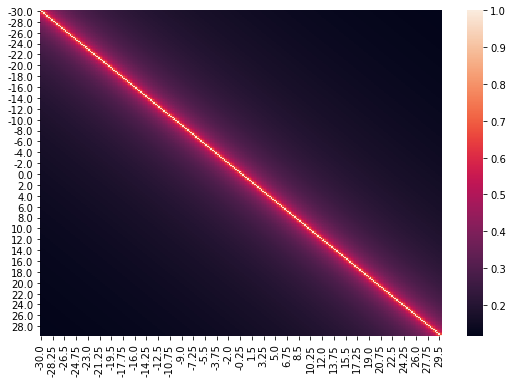

In [5]:
def compute_reward(y_pred, y_true, power=2):
    loss = np.power(np.abs(y_pred - y_true), power)
    return 1/ (1 + np.sqrt(loss))

limit = 30
round_factor = 3
x = np.arange(-limit, limit, 0.25)
y = np.arange(-limit, limit, 0.25)
xx, yy = np.meshgrid(x, y, sparse=True)

f = test()
z = compute_reward(xx, yy,  power=1)
z_df = (pd.DataFrame(z)
        .set_index(np.round(x, round_factor))
        .rename(columns={
            i:val for (i, val) in enumerate(np.round(y, round_factor))
        }))

f, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(z_df)

### Dataset generation

In [23]:
N = 1e5
p = 20
dataset = gen_dataset(p=p, N=N, intercept=.5, drift=False)

### Training and bandits

In [24]:
l2_val=[1e-6, 1e-4, 1e-2, 1e-1, 1e-0, 2, 3]
optimz = [optim.SGD, optim.Adam]

In [27]:
from itertools import product

def get_models():
    grid = product(
        l2_val,
        [preprocessing.StandardScaler, preprocessing.MaxAbsScaler, preprocessing.MinMaxScaler, preprocessing.RobustScaler],
        optimz
    )
    
    return [generate_pipeline(l2=l2, scaler=scaler, optimizer=optimizer) for (l2, scaler, optimizer) in grid]

In [28]:
def generate_pipeline(lr=0.2, l2=0, scaler=None, optimizer=None):
    if scaler is None:
        scaler =  preprocessing.MinMaxScaler()
    if optimizer is None:
        optimizer = optim.SGD

    pipeline = compose.Pipeline(
        scaler,
        linear_model.LinearRegression(optimizer=optimizer(), l2=l2)
    )
    
    return pipeline

In [29]:
mae = metrics.MSE()
take_N = 50000

f = test()
f = compute_reward
default_par = dict(compute_reward=f,
                   metric=mae, 
                   verbose=False,
                   save_rewards=True)

bandits = {
    "epsilon" : EpsilonGreedyBandit(models=get_models(), epsilon=0.1, reduce_epsilon=None, **default_par),
    "ucb"     : UCBBandit(models=get_models(), delta=0.5, **default_par),
    "random"  : RandomBandit(models=get_models(), **default_par),
    #"exp3"    : Exp3Bandit(models=get_models(), gamma=0.1, **default_par)
}


bandit_oracle = OracleBandit(models=get_models(), **default_par)

print_every = N // 10

gen = gen_stream(dataset, take=take_N)
#gen = dataset.take(take_N)

for i, (x, y) in tqdm.tqdm(enumerate(gen)):
    
    for bandit in bandits.values():
        bandit.learn_one(x=x, y=y)
    
    bandit_oracle.learn_one(x=x, y=y)
    
    if i >= 2500:
        pass#break
    
    
#print(bandit.percentage_pulled)

50000it [20:50, 40.00it/s]


### Inspecting oracle results

<AxesSubplot:>

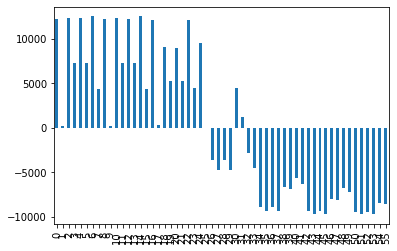

In [30]:
cumsum_final = pd.Series(np.array(bandit_oracle.rewards).cumsum(axis=0)[-1,:])
(cumsum_final - cumsum_final.mean()).plot(kind="bar")

### Comparing results between bandits

<AxesSubplot:>

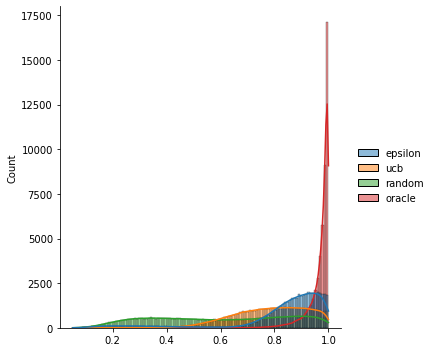

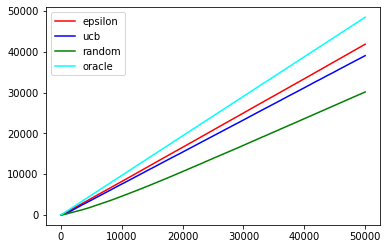

In [31]:
df_rewards = pd.DataFrame({label: bandit.rewards for (label, bandit) in bandits.items()})
df_rewards["oracle"] = bandit_oracle.max_rewards

sns.displot(df_rewards, kde=True)

(df_rewards
 .cumsum()
 .plot(color=["red", "blue", 'green', "cyan" ,"magenta"])
)

<AxesSubplot:>

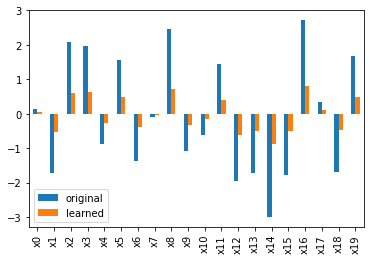

In [190]:
pd.DataFrame({"original": {feature_name:beta 
                           for (feature_name, beta) 
                           in zip(dataset.feature_names, dataset.beta)},
              "learned": bandits["ucb"].best_model["LinearRegression"].weights}).plot(kind="bar")